# FerPlus data preparation

In this file we will prepare the FerPlus dataset for our model. We will clean, augment and split some data.

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
from math import ceil
from sklearn import model_selection
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Set your own path where these files are located using this path.

In [2]:
os.chdir(os.getcwd() + '/data/')

The function below will read the data files and reshape a pixel string to an image array.

In [4]:
# Loads csv files and appends pixels to X and labels to y
def preprocess_data():
    data = pd.read_csv('fer2013.csv')
    labels = pd.read_csv('fer2013new.csv')

    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    n_samples = len(data)
    w = 48
    h = 48

    y = np.array(labels[orig_class_names])
    X = np.zeros((n_samples, w, h, 1))
    for i in range(n_samples):
        X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

    return X, y

We delete unnesecary columns and will normalize the data.

In [5]:
def clean_data_and_normalize(X, y):
    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    # Using mask to remove unknown or NF images
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('unknown')
    X = X[mask]
    y = y[mask]

    # Convert to probabilities between 0 and 1
    y = y[:, :-2] * 0.1

    # Add contempt to neutral and remove it
    y[:, 0] += y[:, 7]
    y = y[:, :7]

    # Normalize image vectors
    X = X / 255.0

    return X, y

Split all data in train, test and validation sets for our model.

In [6]:
def split_data(X, y):
    test_size = ceil(len(X) * 0.1)

    # Split Data
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size,
                                                                      random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test

Rotate images by a certain degree and shift the images.

In [7]:
def data_augmentation(x_train):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen

Created a for loop that will run through 'datagen' and show 25 of the images.

In [8]:
def show_augmented_images(datagen, x_train, y_train):
    it = datagen.flow(x_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(it.next()[0][0]), cmap='gray')
        # plt.xlabel(class_names[y_train[i]])
    plt.show()

Call all functions

In [9]:
X, y = preprocess_data()
X, y = clean_data_and_normalize(X, y)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)
datagen = data_augmentation(x_train)

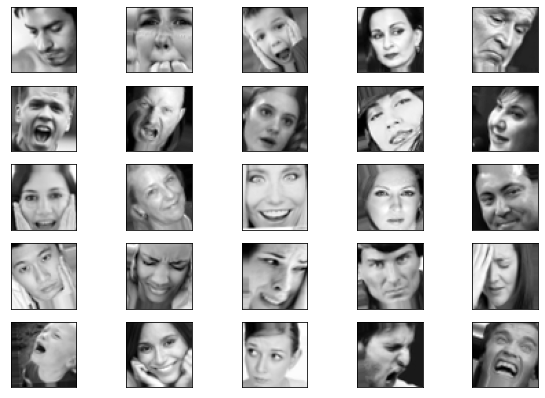

In [10]:
show_augmented_images(datagen, x_train, y_train)

In [11]:
pickle.dump([datagen, x_train, y_train, x_val, y_val, x_test, y_test], open("newDatagen", "wb"))